In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import StrMethodFormatter


In [15]:
def get_metric_file(ckpt_folder, metric):
    
    if metric == 'test_acc':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'loss_acc_test.pkl')
    elif metric == 'loss':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'loss_acc_test.pkl')
    elif metric == 'CKA':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'CKA_mixup_alpha_16.0.pkl')
    elif 'hessian' in metric:
        file_name = os.path.join(ckpt_folder, 'metrics/', 'hessian_test.pkl')
    elif metric == 'mode_connectivity':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'curve_test.npz')
    elif metric == 'L2':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'model_dist.pkl')
    elif metric == 'neural_eff':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'neural_eff.pkl')
    elif metric == 'fisher':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'fisher.pkl')
    elif metric == 'covar':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'covar.pkl')
    elif metric == 'jacobian':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'jacobian.pkl')
    elif metric == 'emd':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'emd.pkl')
    elif metric == 'signal_eff':
        file_name = os.path.join(ckpt_folder, 'metrics/', 'signal_eff.pkl')
    print(file_name)
    assert os.path.exists(file_name)
    return file_name

In [16]:
def get_metric_val(metric_file, metric):
    
    if metric == 'test_acc':
        results = pickle.load(open(metric_file, 'rb'))
        return np.mean([results[n]['accuracy'] for n in range(5)])
    if metric == 'loss':
        results = pickle.load(open(metric_file, 'rb'))
        return np.mean([results[n]['loss'] for n in range(5)])
    elif metric == 'CKA':
        results = pickle.load(open(metric_file, "rb"))
        CKA_all = []
        for exp_ind1 in range(5):
            for exp_ind2 in range(5):
                if exp_ind1 != exp_ind2:
                    CKA_all.append(results['representation_similarity'][exp_ind1][exp_ind2][-1])
        return np.mean(CKA_all)
    elif 'hessian' in metric:
        results = pickle.load(open(metric_file, "rb"))
        if '_e' in metric:
            return np.log(np.mean([results[n]['top_eigenvalue'][0] for n in range(5)]))
        elif '_t' in metric:
            return np.log(np.mean([results[n]['trace'] for n in range(5)]))
    elif metric == 'mode_connectivity':
        result = np.load(metric_file)['tr_err']
        u = np.argmax(np.abs(result - (result[0] + result[4])/2))
        return (result[0] + result[4])/2 - result[u]
    elif metric == 'L2':
        results = pickle.load(open(metric_file, "rb"))
        dist_all = []
        for exp_ind1 in range(5):
            for exp_ind2 in range(5):
                if exp_ind1 != exp_ind2:
                    dist_all.append(results['model_distance'][exp_ind1][exp_ind2]['dist'])
        return np.mean(dist_all)
    elif metric == 'neural_eff':
        result = np.load(metric_file, allow_pickle=True)
        return np.average(result)
    elif metric == 'fisher':
        result = np.load(metric_file, allow_pickle=True)
        print(result)
        return np.average(result)
    elif metric == 'covar':
        result = np.load(metric_file, allow_pickle=True)
        result = [res.detach().numpy() for res in result]
        return np.average(result)
    elif metric == 'jacobian':
        result = np.load(metric_file, allow_pickle=True)
        return np.average(result)
    elif metric == 'emd':
        results = pickle.load(open(metric_file, "rb"))
        dist_all = []
        for exp_ind1 in range(5):
            for exp_ind2 in range(5):
                if exp_ind1 != exp_ind2:
                    dist_all.append(results['model_emd'][exp_ind1][exp_ind2]['emd'])
        return np.average(dist_all)
    elif metric == 'signal_eff':
        results = pickle.load(open(metric_file, "rb"))
        return np.average(results['q'])

In [20]:
def vminmax(metric):
    if metric == 'test_acc':
        vmin, vmax = 0.6, 0.8
    elif metric == 'loss':
        vmin, vmax = 25, 40
    elif metric == 'CKA':
        vmin, vmax = 0.7, 1
    elif metric == 'mode_connectivity':
        vmin, vmax = -0.4, 0.4
    elif metric == 'L2':
        vmin, vmax = 0, 20
    elif metric == 'hessian_e':
        vmin, vmax = 0, 6
    elif metric == 'hessian_t':
        vmin, vmax = 3, 8
    elif metric == 'neural_eff':
        vmin, vmax = 0, 1     
    elif metric == 'fisher':
        vmin, vmax = 0, 0.3
    elif metric == 'covar':
        vmin, vmax = 0, 1     
    elif metric == 'jacobian':
        vmin, vmax = -5, 40
    elif metric == 'emd':
        vmin, vmax = 0, 0.2
    elif metric == 'signal_eff':
        vmin, vmax = 0, 0.1
    return vmin, vmax

In [21]:
def plot_2Dphase(phase2D, x_label_list, y_label_list, metric, metric_title):
    
    fig, ax = plt.subplots(1,1, figsize = (5,4))
    
    X,Y = np.meshgrid(x_label_list, y_label_list)
    vmin, vmax = vminmax(metric)
    print(X,Y)
    if metric == 'mode_connectivity':
        pos = ax.pcolormesh(X,Y,phase2D, vmin=vmin, vmax=vmax, cmap="seismic")
    elif metric in ['L2', 'loss', 'hessian_e', 'hessian_t']:
        pos = ax.pcolormesh(X,Y,phase2D, vmin=vmin, vmax=vmax, cmap="viridis_r")
    else:
        pos = ax.pcolormesh(X,Y,phase2D, vmin=vmin, vmax=vmax, cmap="viridis")#,edgecolors='k')
    
    print(phase2D)
    
    ax.set_xscale("linear")
                
    ax.set_yticks(y_label_list)
    ax.set_yscale("log")
    ax.invert_yaxis()
    
    ax.set_xlabel('Bit Width', fontsize=20)
    ax.set_ylabel(f'T (Learning Rate)', fontsize=20)
    ax.set_title(metric_title, fontsize=20)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = plt.colorbar(pos, cax=cax)
    cbar.ax.tick_params(labelsize=18)
    plt.tight_layout()
    plt.savefig(f'{metric}.png')

<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_65793/1729614155.py:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if metric is 'fisher':
/tmp/ipykernel_65793/1729614155.py:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if metric is 'covar':


../../checkpoint/different_knobs_subset_10/lr_0.1/lr_decay/JT_6b/metrics/fisher.pkl
[tensor(72615.1953), tensor(46838.1406), tensor(91342.5859), tensor(65626.0234), tensor(57663.8281)]
../../checkpoint/different_knobs_subset_10/lr_0.05/lr_decay/JT_6b/metrics/fisher.pkl
[tensor(129442.0312), tensor(130655.4297), tensor(149186.4219), tensor(143694.2188), tensor(152650.7188)]
../../checkpoint/different_knobs_subset_10/lr_0.025/lr_decay/JT_6b/metrics/fisher.pkl
[tensor(155863.9844), tensor(126587.1719), tensor(110757.3359), tensor(123089.8281), tensor(96193.6953)]
../../checkpoint/different_knobs_subset_10/lr_0.0125/lr_decay/JT_6b/metrics/fisher.pkl
[tensor(207630.8594), tensor(192626.8281), tensor(226103.1719), tensor(253648.0312), tensor(237973.4844)]
../../checkpoint/different_knobs_subset_10/lr_0.00625/lr_decay/JT_6b/metrics/fisher.pkl
[tensor(260881.2344), tensor(202089.2812), tensor(229912.6250), tensor(245734.3438), tensor(216657.5469)]
../../checkpoint/different_knobs_subset_10/lr_

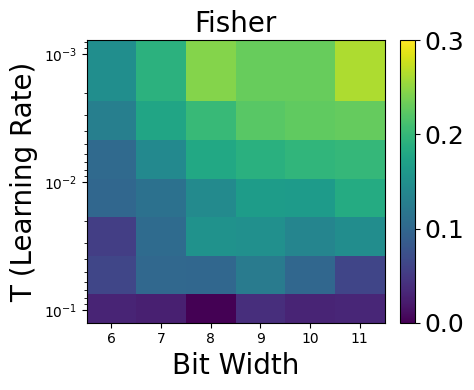

In [22]:
width_list = [6,7,8,9,10,11,
             ]# [6,7, #[2, 3, 4, 6, 8, 11, 16, 23, 32, 45, 64, 91, 128]

bs_list = [16, 24, 32, 44, 64, 92, 128, 180, 256, 364, 512, 724, 1024]
lr_list = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
temp_list = lr_list

# metric_list = ['test_acc', 'loss', 'hessian_e', 'hessian_t', 'L2', 'CKA', 
#                'mode_connectivity', 'neural_eff', 'fisher', 'covar', 'jacobian', 'emd']
# metric_title_list = ['Test accuracy','Test loss', 'Log Hessian eigenvalue', 'Hessian trace', 
#                     'Model distance (L2)', 'CKA similarity', 'Mode connectivity', 'Neural Efficiency' ,'Fisher Trace', 'Covariance Trace', 'Jacobian', 'EMD']

metric_list = ['fisher']
metric_title_list = ['Fisher']

for metric, metric_title in zip(metric_list, metric_title_list):

    lenx = len(width_list)
    leny = len(temp_list)
    phase2D = np.zeros((leny, lenx))
    
    for j,width in enumerate(width_list):
        for i,temp in enumerate(temp_list):
            ckpt_folder = f'../../checkpoint/different_knobs_subset_10/lr_{temp}/lr_decay/JT_{width}b/'
            metric_file = get_metric_file(ckpt_folder, metric)
            phase2D[i][j] = get_metric_val(metric_file, metric)
    if metric is 'fisher':
        phase2D[0][2] = 0
        scale = np.sqrt((phase2D**2).sum())
        phase2D /= scale
    if metric is 'covar':
        phase2D[0][2] = 0
        scale = np.sqrt((phase2D**2).sum())
        phase2D /= scale
    # if metric is 'jacobian':
    #     phase2D[0][2] = 0
    #     scale = np.sqrt((phase2D**2).sum())
    #     phase2D /= scale
    print(width_list)
    print(temp_list)
    plot_2Dphase(phase2D, width_list, temp_list, metric, metric_title)


In [13]:
phase2D.max() 
phase2D.min() 


4.282189869880677